In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import PIL
from PIL import Image
import torchvision
from torchvision import models
import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random

# The Preprocessing part is done.

In [2]:
folder_path = ('677images')

file_path = []
for root, dir, files in os.walk(folder_path):
    for f in files:
        if f=='.DS_Store':
            continue
        file_info = os.path.join(root, f)
        file_path.append(file_info)

lst = [e[10:] for e in file_path]
lst[0:5]

['Green/Light_Green_65.jpg',
 'Green/Light_Green_71.jpg',
 'Green/Light_Green_59.jpg',
 'Green/Light_Green_136.jpg',
 'Green/Light_Green_122.jpg']

In [3]:
classes = []
for i in lst:
    split = i.split('/')[0]
    classes.append(split)
classes[180:185]

['Green', 'Red_Straight', 'Red_Straight', 'Red_Straight', 'Red_Straight']

In [4]:
import pandas as pd

df1 = pd.DataFrame(lst,columns=['FNAME'])
df2 = pd.DataFrame(classes, columns=['CLASS'])
df1.insert(0,'ID',range(0,len(df1)))
df2.insert(0,'ID',range(0,len(df2)))
result = pd.merge(df1, df2, on='ID')
result.head(n=5)

,ID,FNAME,CLASS
0,0,Green/Light_Green_65.jpg,Green
1,1,Green/Light_Green_71.jpg,Green
2,2,Green/Light_Green_59.jpg,Green
3,3,Green/Light_Green_136.jpg,Green
4,4,Green/Light_Green_122.jpg,Green


In [5]:
import numpy as np

conditions = [
    (result['CLASS'] == 'Green'),
    (result['CLASS'] == 'Green_Left'),
    (result['CLASS'] == 'Green_Right'),
    (result['CLASS'] == 'Green_Straight'),
    (result['CLASS'] == 'Red'),
    (result['CLASS'] == 'Red_Left'),
    (result['CLASS'] == 'Red_Right'),
    (result['CLASS'] == 'Red_Straight'),
    (result['CLASS'] == 'Yellow'),
]
choices = [0,1,2,3,4,5,6,7,8]
result['CLASS'] = np.select(conditions, choices)
result.head(n=5)

,ID,FNAME,CLASS
0,0,Green/Light_Green_65.jpg,0
1,1,Green/Light_Green_71.jpg,0
2,2,Green/Light_Green_59.jpg,0
3,3,Green/Light_Green_136.jpg,0
4,4,Green/Light_Green_122.jpg,0


In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(result, test_size=0.2, random_state=677)
train_df['SPLIT'] = 1
test_df['SPLIT'] = 0
train_df.head(n=10)

,ID,FNAME,CLASS,SPLIT
231,231,Red_Right/Light_Red_Right_25.jpg,6,1
166,166,Green/Light_Green_57.jpg,0,1
478,478,Red_Left/Light_Red_Left_38.jpg,5,1
636,636,Green_Right/Light_Green_Right_3.jpg,2,1
645,645,Green_Right/Light_Green_Right_38.jpg,2,1
267,267,Green_Straight/Light_Green_Straight_27.jpg,3,1
287,287,Red/Light_Red_85.jpg,4,1
81,81,Green/Light_Green_145.jpg,0,1
536,536,Yellow/Light_Yellow_12.jpg,8,1
433,433,Red/Light_Red_185.jpg,4,1


In [7]:
train_path = 'TrafficLights/train'
if not os.path.exists(train_path):
    os.makedirs(train_path)

test_path = 'TrafficLights/test'
if not os.path.exists(test_path):
    os.makedirs(test_path)

In [8]:
import shutil

for _, row in train_df.iterrows():
    path = '677images/' + row['FNAME']
    label = 'TrafficLights/train/' + row['FNAME'].split('.')[0].split('/')[0]
    if not os.path.exists(label):
        os.makedirs(label)

    target = label +'/'+ row['FNAME'].split('/')[-1]
    shutil.move(path,target)

In [9]:
for _, row in test_df.iterrows():
    path = '677images/' + row['FNAME']
    label = 'TrafficLights/test/' + row['FNAME'].split('.')[0].split('/')[0]
    if not os.path.exists(label):
        os.makedirs(label)

    target = label +'/'+ row['FNAME'].split('/')[-1]
    shutil.move(path,target)

# Start from here

In [4]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.4829, 0.4908, 0.4228]
std = [0.2297, 0.2252, 0.2601]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
    #   torchvision.transforms.RandomHorizontalFlip(p = 0.5),
    #   torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = 'TrafficLights/train/',
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 4,
    shuffle=True
)

test = torchvision.datasets.ImageFolder(
    root = 'TrafficLights/test/',
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 4,
    shuffle=True
)

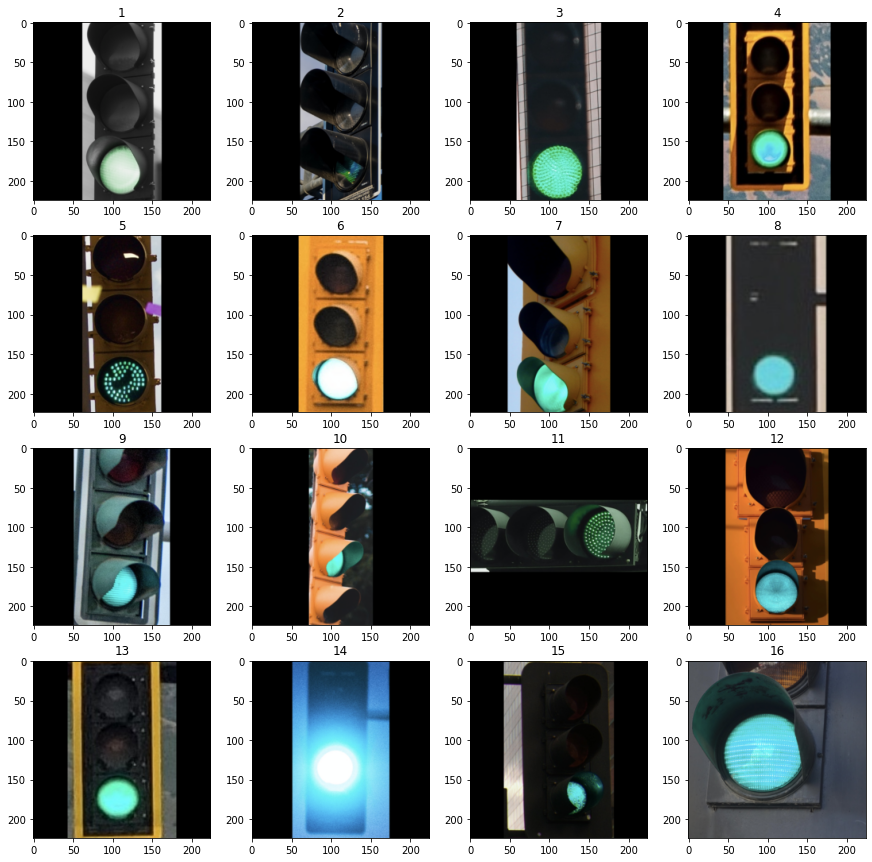

In [4]:
analysis_path = 'Analysis/'
if not os.path.exists(analysis_path):
  os.makedirs(analysis_path)

fig, axes = plt.subplots(4,4,figsize= (15,15))

for i in range(16):

  img = train[i][0].numpy().transpose(1, 2, 0)
  img = np.clip((std * img) + mean, 0, 1)
  axes.flat[i].imshow(img)
  axes.flat[i].set_title(str(train[i][1]+i+1))

# Follow aspect ratio of either 1:1 or 1.68:1 (8.5, 4.75/5)
fig.savefig('Analysis/train_image_transformations.jpg', dpi=300, bbox_inches='tight')  
fig.savefig('Analysis/train_image_transformations.pdf', dpi=300, bbox_inches='tight')  
plt.show()

In [5]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet(9)

In [ ]:

# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context
# AlexNet_Model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
# AlexNet_Model.eval()

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(AlexNet_Model.parameters(), lr=1e-3, momentum=0.9)

In [35]:
# # from torch.nn.modules import dropout
# # from torch.nn.modules.activation import ReLU
# class AlexNet(nn.Module):
#     def __init__(self, output_dim = 10):
#         super().__init__()

#         self.features = nn.Sequential(
#             nn.Conv2d(3,64,3,2,1),
#             nn.MaxPool2d(2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64,192,3,padding=1),
#             nn.MaxPool2d(2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(192,384,3,padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384,256,3,padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256,256,3,padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
#             nn.ReLU(inplace=True)
#         )
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(256*2*2,4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096,4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096,output_dim)
#         )
#     def forward(self,x):
#         x = self.features(x)
#         h = x.view(x.shape[0],-1)
#         x = self.classifier(h)
#         return x,h

# model = AlexNet(output_dim=9)

In [36]:
# def init_parameter(m):
#   if isinstance(m,nn.Conv2d):
#     nn.init.kaiming_normal_(m.weight.data,nonlinearity='relu')
#     nn.init.constant_(m.bias.data,0)
#   elif isinstance(m,nn.Linear):
#     nn.init.xavier_normal_(m.weight.data,gain= nn.init.calculate_gain('relu'))
#     nn.init.constant_(m.bias.data,0)

# model.apply(init_parameter)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
optimizer = optim.SGD(params = model.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [7]:
from datetime import datetime
# import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

model.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data, target) in enumerate(train_loader):
    model.train()
    # if cuda:
    #   data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()

    out = model(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    current_loss = loss.cpu().data.item()
    running_loss += current_loss

    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  test_running_loss = 0
  model.eval()

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      # if cuda:
      #   data, target = data.cuda(), target.cuda()

      out = model(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

    LTest = test_running_loss/len(test_loader)

  LTrain = running_loss/len(train_loader)
  accu = 100.*correct/total

  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 0.030	  Epoch Loss: 0.144	 Train Acc: 94.784	 Test Loss: 0.885	: 100%|██████████| 50/50 [1:22:15<00:00, 106.00s/it]

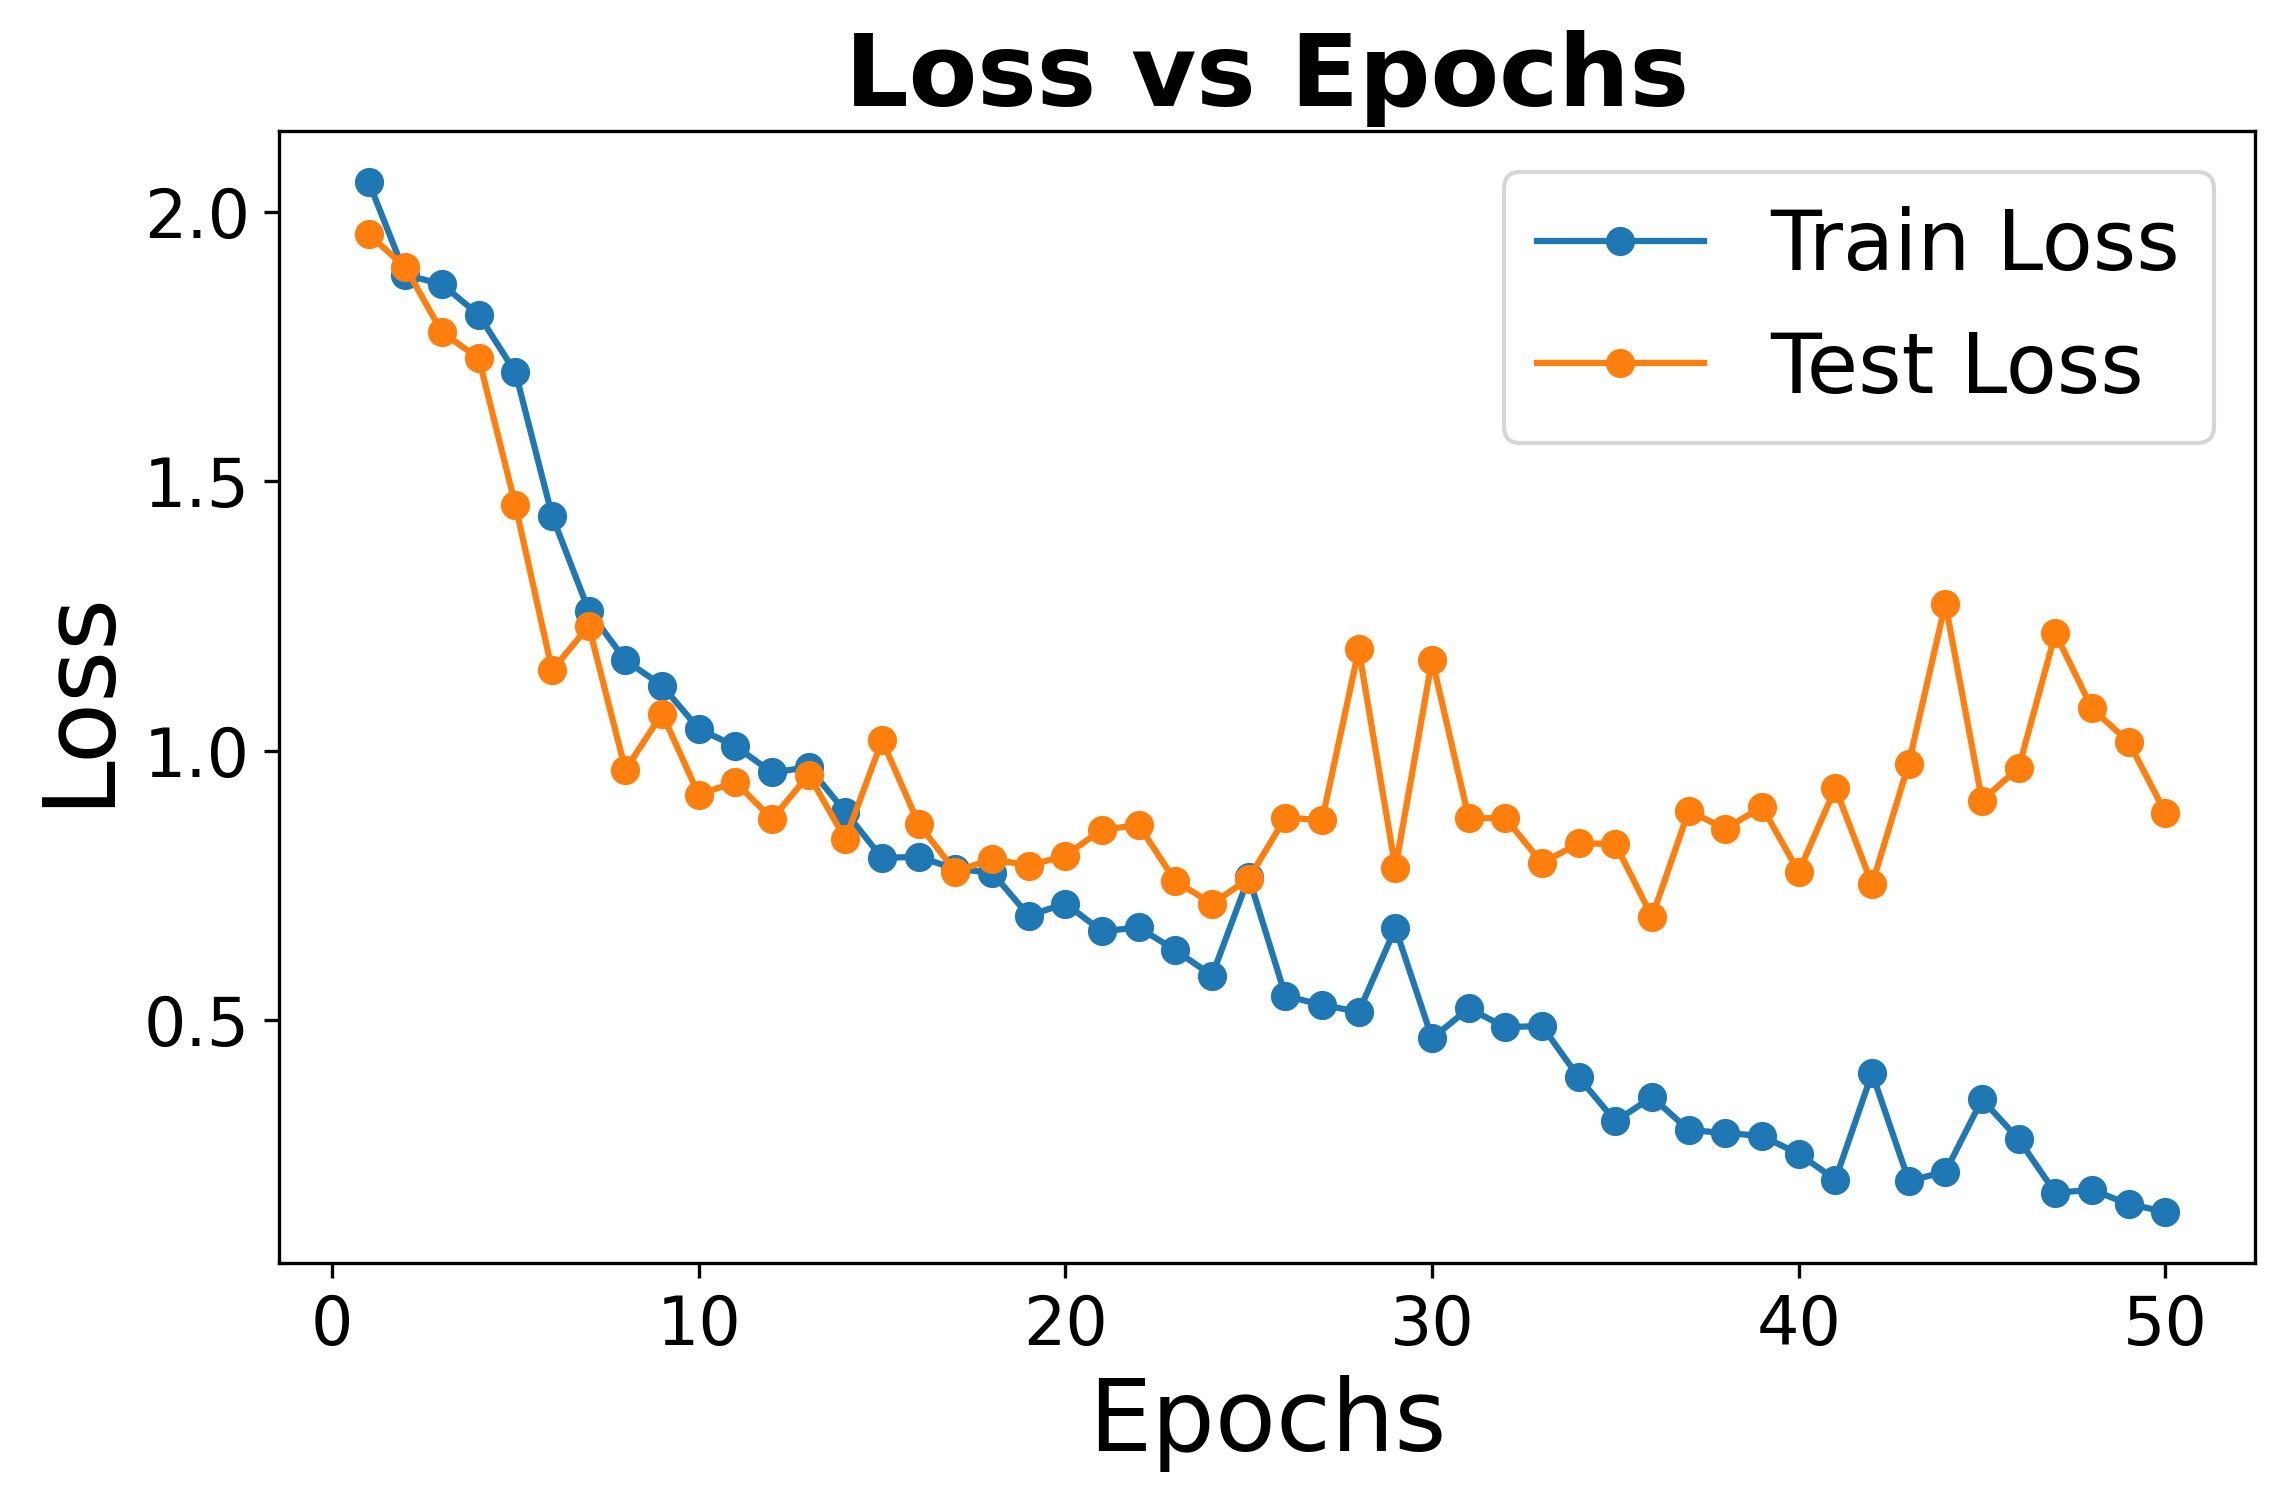

In [8]:
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss", linewidth = 1.5)
ax.plot(x, test_loss, '-o', label = "Test Loss", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Loss", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("Loss vs Epochs", fontsize = 24, fontweight = 'bold')

plt.savefig("Loss vs Epochs.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("Loss vs Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()


In [15]:
print(np.round(test_loss,2))

[1.96 1.9  1.78 1.73 1.45 1.15 1.23 0.96 1.07 0.92 0.94 0.87 0.96 0.84
 1.02 0.86 0.78 0.8  0.79 0.81 0.85 0.86 0.76 0.72 0.76 0.88 0.87 1.19
 0.78 1.17 0.87 0.87 0.79 0.83 0.83 0.69 0.89 0.85 0.9  0.77 0.93 0.75
 0.98 1.27 0.91 0.97 1.22 1.08 1.02 0.88]


In [10]:
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

model.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        # if cuda:
        #   data, target = data.cuda(), target.cuda()
        
        out = model(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

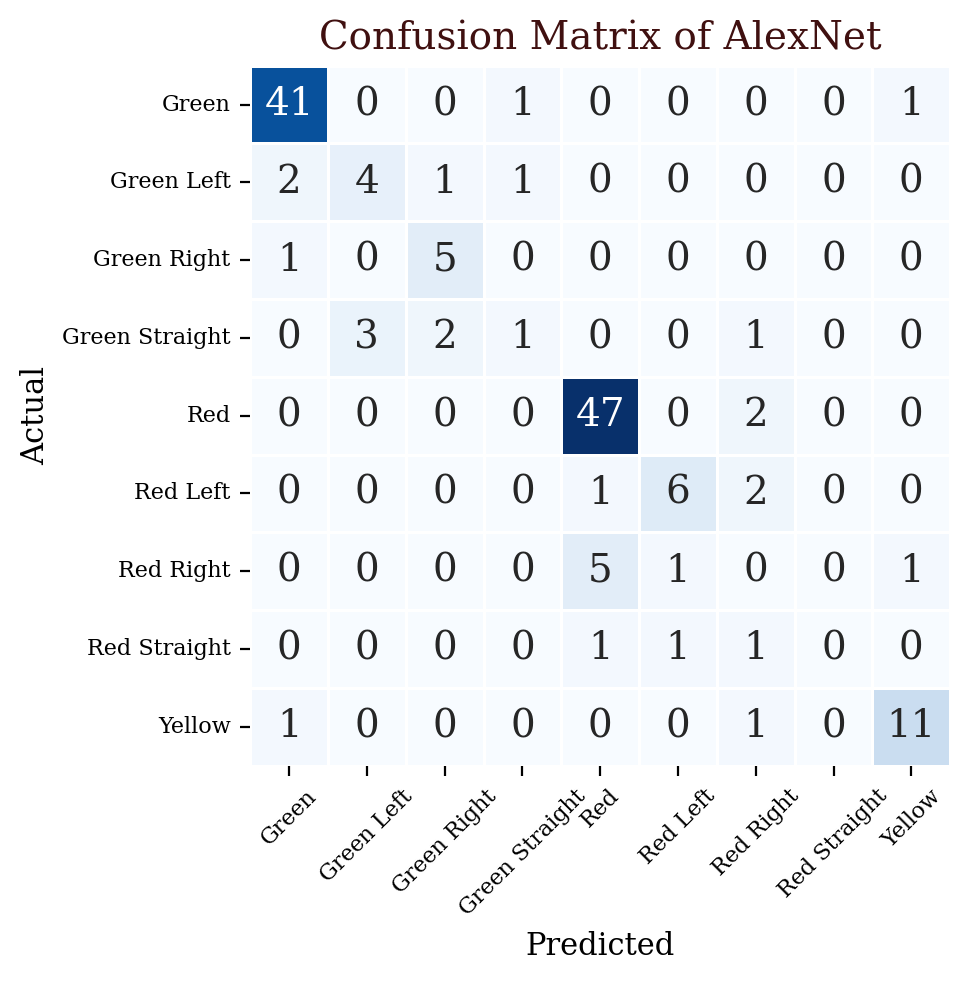

In [55]:
from matplotlib.pyplot import xlabel, xticks
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# conf = confusion_matrix(y_pred= pred, y_true = correct)

# fig,ax = plt.subplots(figsize = (15,15))

# plt.imshow(conf, interpolation='none', cmap = 'YlOrRd_r')


conf = confusion_matrix(correct,pred)


plt.figure(figsize=(5,5),dpi=200)

sns.heatmap(conf,cmap='Blues',cbar=False,annot=True,
            xticklabels=['Green','Green Left','Green Right','Green Straight','Red','Red Left','Red Right','Red Straight','Yellow'],
            # xticks = dict(family = 'Georgia'),
            yticklabels=['Green','Green Left','Green Right','Green Straight','Red','Red Left','Red Right','Red Straight','Yellow'],
            linewidths=0.5,
            annot_kws={'size':14,
                       'weight':'normal',
                       'family':'Serif'})
plt.xlabel('Predicted', fontsize = 11,font = dict(family = 'Serif')) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 11,font = dict(family = 'Serif')) 
plt.xticks(rotation=45,font=dict(family='Serif',size = 8))
plt.yticks(font=dict(family='Serif',size = 8))
plt.title("Confusion Matrix of AlexNet",fontsize=14,family='Serif',color='#401010',fontweight=10)
plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.2)
plt.savefig('AlexNet_CM.jpg')
plt.show()

In [12]:
test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 1,
    shuffle=True
)

In [13]:

categories = [0,1,2,3,4,5,6,7,8]


top1 = 0
top5 = 0
with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        # if cuda:
        #   data, target = data.cuda(), target.cuda()
        out = model(data)
        probabilities = torch.nn.functional.softmax(out[0], dim=0)
        top1_prob, top1_catid = torch.topk(probabilities, 1)
        prob_1 = []
        for i in range(top1_prob.size(0)):
            prob_1.append(categories[top1_catid[i]])
        if target[_].cpu().item() in prob_1:
            top1+=1
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        prob_5 = []
        for i in range(top5_prob.size(0)):
            prob_5.append(categories[top5_catid[i]])
        if target[_].cpu().item() in prob_5:
            top5+=1
    print(top1,top5)

115 144
